In [1]:
import re
import os

import numpy as np

from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.variables import Variables

import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
from pprint import pprint

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

In [2]:
verbose = False

Shell.mkdir('./images')
log_dir = "../experiments/rivanna/localscratch"
notebook = Shell.map_filename(f"{log_dir}/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/cloudmesh_mllog.log").path

# print ("NOTEBOOK", notebook)
# os.system(f"ls {notebook}")

mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [3]:
fixed_dicts = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    # print('d', working_line)
    # print(type(working_line))

    # interpreting scientific values
    parse_line = working_line['value']['extrastring']
    parse_list = parse_line.split()

    # this function returns the value after a specified word
    def looking_for(seeking_value: str):
        found_it = False
        for word in parse_list:
            if found_it:
                return word
            if word == seeking_value:
                found_it = True
                continue

    validation_value = looking_for('Validation')
    if validation_value:
        working_line['value']['validation'] = validation_value
    training_value = looking_for('Training')
    if training_value:
        working_line['value']['training'] = training_value

    list_of_values = []
    working_line['value']['MSE'] = {}
    for word in parse_list:
        if '=' in word and ('F' in word or 'S' in word or 'E' in word):
            temp_word = word.split('=')
            working_line['value']['MSE'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
        elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
            temp_word = word.split(':')
            working_line['value'][temp_word[0]] = temp_word[1]
    working_line['value']['title'] = working_line['key']
    working_line['key'] = 'result'

    program_title = looking_for('UTC')
    working_line['value']['program'] = program_title
    nnse = looking_for('summedErr/SummedObs')
    working_line['value']['NNSE'] = nnse
    comment = looking_for('TOTAL')
    working_line['value']['comment'] = comment

    future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
    try:
        working_line['value']['future'] = future.group(1)
    except AttributeError:
        pass

    loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
    working_line['value']['location_summed_results'] = loc_sum.group(1)
    del working_line['value']['extrastring']

    fixed_dicts.append(working_line)


In [4]:
if verbose:

    for fixed_dict in fixed_dicts:
        pprint(fixed_dict)
    print(len(fixed_dicts))
        # print(working_line)


In [5]:
list_of_value_dicts_training = []
list_of_value_dicts_validation = []
fails = 0
for dictionary in fixed_dicts:
    # try:
    #     if dictionary['value']['training']:
    #         list_of_value_dicts_training.append(dictionary['value'])
    # except KeyError:
    #     list_of_value_dicts_validation.append(dictionary['value'])
    if dictionary.get('value', None).get('training', None):
        list_of_value_dicts_training.append(dictionary['value'])
    elif dictionary.get('value', None).get('validation', None):
        list_of_value_dicts_validation.append(dictionary['value'])
    else:
        fails += 1
print('fails:', fails)
    #list_of_value_dicts.append(dictionary['value'])

for iterated_dictionary in list_of_value_dicts_training:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']

for iterated_dictionary in list_of_value_dicts_validation:
    temp_mse = iterated_dictionary['MSE']
    iterated_dictionary['MSE_F'] = temp_mse['F']
    iterated_dictionary['MSE_S'] = temp_mse['S']
    iterated_dictionary['MSE_E'] = temp_mse['E']



fails: 0


In [6]:
df_training = pd.DataFrame(list_of_value_dicts_training)
df_validation = pd.DataFrame(list_of_value_dicts_validation)

df_training.drop('MSE', axis=1, inplace=True)
df_validation.drop('MSE', axis=1, inplace=True)

df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

dataframes = [df_training, df_validation]

for dataframe in dataframes:
    for index, row in dataframe.iterrows():
        dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

        if dataframe.loc[index, 'future'] is np.nan:
            temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
            remove_words = ['Magnitude', 'Mag']
            for word in remove_words:
                if word in temp_string_list:
                    temp_string_list.remove(word)
            new_string = " ".join(temp_string_list)
            dataframe.loc[index, 'name'] = new_string

        else:
            added_string = ''
            temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
            if 'Months' in temp_string_list:
                if '6' in temp_string_list:
                    added_string = '6M '
                elif '3' in temp_string_list:
                    added_string = '3M '
            elif 'Year' in temp_string_list:
                added_string = '1Y '
            elif '2' in temp_string_list and 'weeks' in temp_string_list and 'Now' in temp_string_list:
                added_string = 'Now '
            dataframe.loc[index, 'name'] = added_string + dataframe.loc[index, 'future'].split()[-1]
    dataframe.sort_values('NNSE', inplace=True)


    dataframe.pop("NNSEpercent")
    last = len(df_training.keys()) -1
    DELETE = -1000

    for index, what in [(0, 'name'),
                        (1,"NNSE"),
                        (DELETE, "location_summed_results"),
                        (DELETE, "comment"),
                        (DELETE, "title"),
                        (DELETE, "program"),
                        (DELETE, "future")]:
        col = dataframe.pop(what)
        if index != DELETE:
            dataframe.insert(index, what, col)



In [7]:
display(df_training)

,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV
3,Year Back,0.1913,0.72242,0.582,NaN,0.614,NaN,0.007831,0.008627,0.006883,0.587,0.636
6,6M 2wk+7AVG,0.1927,0.72242,0.582,0.581,0.614,0.607,0.006939,0.007617,0.006126,NaN,NaN
10,6M 2wk+13AVG,0.1970,0.72242,0.582,0.581,0.614,0.607,0.008528,0.009321,0.007569,NaN,NaN
2,6 Months Back,0.2016,0.72242,0.582,0.581,0.614,0.607,0.005805,0.006474,0.005009,NaN,NaN
11,1Y 2wk+13AVG,0.2326,0.72242,0.582,NaN,0.614,NaN,0.009178,0.01006,0.008111,0.587,0.636
1,3 Months Back,0.2330,0.72242,0.481,NaN,0.313,NaN,0.005381,0.005797,0.004886,0.484,0.375
7,1Y 2wk+7AVG,0.2358,0.72242,0.582,NaN,0.614,NaN,0.008419,0.008635,0.00816,0.587,0.636
5,3M 2wk+7AVG,0.2430,0.72242,0.481,NaN,0.313,NaN,0.006861,0.00718,0.006479,0.484,0.375
15,1Y 2wk+26AVG,0.2516,0.72242,0.582,NaN,0.614,NaN,0.011856,0.012663,0.010864,0.587,0.636
14,6M 2wk+26AVG,0.2517,0.72242,0.582,0.581,0.614,0.607,0.009043,0.009572,0.008392,NaN,NaN


In [8]:
display(df_validation)

,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV
6,6M 2wk+7AVG,0.1952,0.74745,0.582,0.581,0.614,0.607,0.007081,0.007894,0.006105,NaN,NaN
2,6 Months Back,0.2010,0.74745,0.582,0.581,0.614,0.607,0.005979,0.006831,0.004965,NaN,NaN
10,6M 2wk+13AVG,0.2016,0.74745,0.582,0.581,0.614,0.607,0.008521,0.009567,0.007255,NaN,NaN
3,Year Back,0.2045,0.74745,0.582,NaN,0.614,NaN,0.008337,0.009206,0.007302,0.587,0.636
1,3 Months Back,0.2197,0.74745,0.481,NaN,0.313,NaN,0.005441,0.006075,0.004686,0.484,0.375
5,3M 2wk+7AVG,0.2289,0.74745,0.481,NaN,0.313,NaN,0.006845,0.007471,0.006093,0.484,0.375
11,1Y 2wk+13AVG,0.2382,0.74745,0.582,NaN,0.614,NaN,0.009752,0.010536,0.008805,0.587,0.636
7,1Y 2wk+7AVG,0.2495,0.74745,0.582,NaN,0.614,NaN,0.009429,0.009297,0.009587,0.587,0.636
14,6M 2wk+26AVG,0.2644,0.74745,0.582,0.581,0.614,0.607,0.009138,0.0098,0.008325,NaN,NaN
9,3M 2wk+13AVG,0.2662,0.74745,0.481,NaN,0.313,NaN,0.007138,0.007723,0.006431,0.484,0.375


In [9]:
def plot_figure(fig, ax, name="abc", title=None, x=None, y=None, axis_font=12, size=[8,8], x_range=None, y_range=None, visible_xaxis=None):

    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(visible_xaxis)
    fig.set_size_inches(size[0],size[1])
    if title is not None:
        fig.suptitle(title, fontsize=axis_font)

    if y is not None:
        plt.ylabel(y, fontsize=axis_font)
    if x is not None:
        plt.xlabel(x, fontsize=axis_font)
    if x_range is not None:
        plt.xlim(x_range)
    if y_range is not None:
        plt.ylim(y_range)

    # We change the fontsize of minor ticks label
    ax.tick_params(axis='both', which='major', labelsize=axis_font)
    ax.tick_params(axis='both', which='minor', labelsize=axis_font)
    # plt.savefig(f"./images/{name}.svg")
    plt.savefig(f"./images/{name}.png")
    plt.savefig(f"./images/{name}.pdf")


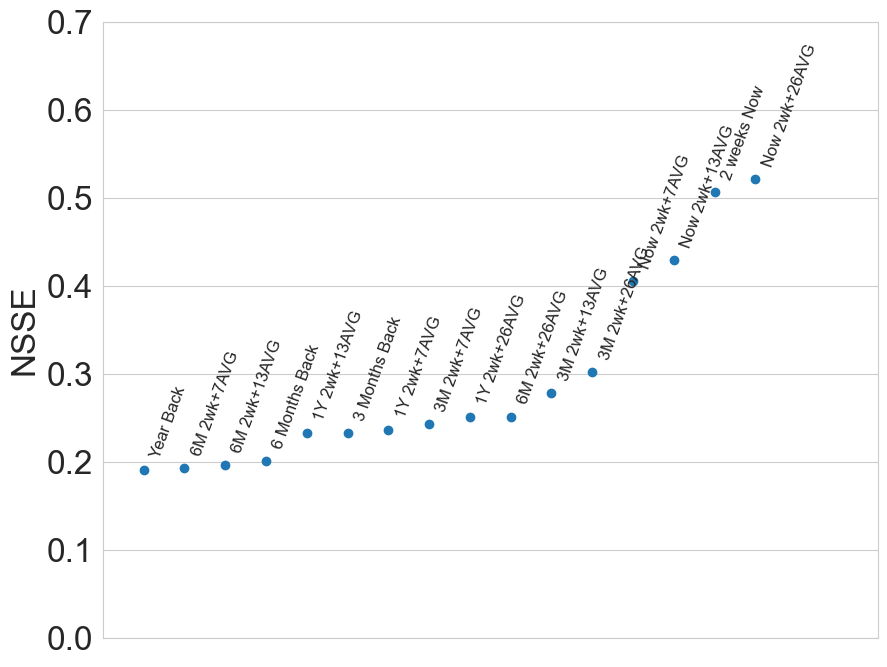

In [10]:
fig, ax = plt.subplots()
df_training['index'] = range(0, len(df_training))
ax.scatter(x=df_training['index'], y=df_training['NNSE'])
# plt.xlabel('index')

# generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
for idx, row in df_training.iterrows():
    ax.annotate('   ' + row['name'], (row['index'], row['NNSE']), rotation=70, fontsize=12, fontfamily="Arial")
plot_figure(fig, ax, title=None, size=[10,8], name="abc", y="NSSE", axis_font=24, y_range=[0,0.7], x_range=[-1,len(df_training) + 2], visible_xaxis=False)

plt.show()

<Figure size 640x480 with 0 Axes>

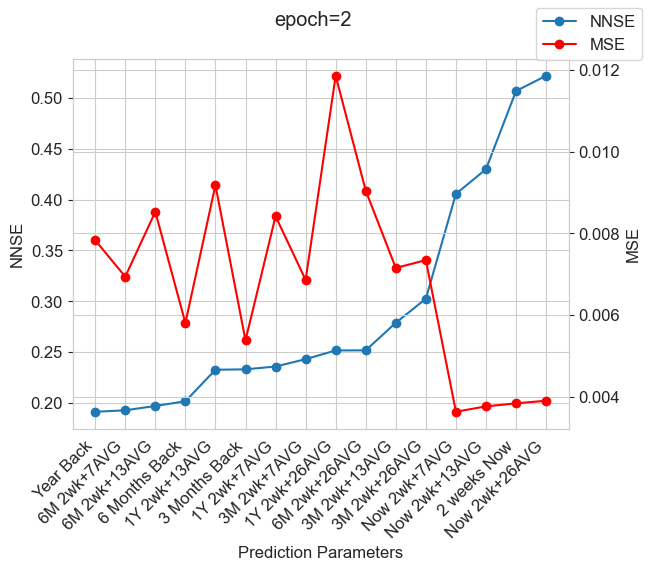

In [11]:
plt.clf()

df_training['MSE'] = df_training['MSE'].astype(float)

# this just creates a new index column
df_training['index'] = range(0, len(df_training))

# fig1, ax = plt.subplots()
# fig1.set_size_inches(20,20)
ax = df_training.plot(x='name', y='NNSE', marker="o", legend=False)
# ax.scatter(x=df_training['2weekIntervals'], y=df_training['NNSE'])
ax1 = ax.twinx()
df_training.plot(x='name', y='MSE', ax=ax1, color='r', marker="o", legend=False)
# ax1.scatter(x=df_training['2weekIntervals'], y=df_training['MSE'], color='r')
# df_training.plot(x="MSE_F", y='index', legend=False, color="r")
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
ax.figure.legend()
plt.suptitle('epoch=2')
plt.xticks(df_training['index'], df_training['name'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Prediction Parameters")
ax.set_ylabel("NNSE")
ax1.set_ylabel("MSE")

plt.show()
# df_training['sortedNNSE'] = df_training.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
# df_training.sort_values(['sortedNNSE', '2weekIntervals'])
# # df_training.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
# plt.plot(df_training['NNSEdecimal'])
# plt.xticks(range(len(df_training['2weekIntervals'])), df_training['2weekIntervals'])
# plt.show()

In [12]:
result_training = df_training.copy()
result_validation = df_validation.copy()

In [13]:
result_training = result_training[['name', 'NNSE']]
result_training.sort_values('NNSE', inplace=True)
result_training.rename(columns={'name': 'Name'}, inplace=True)
display(result_training)

result_validation = result_validation[['name', 'NNSE']]
result_validation.sort_values('NNSE', inplace=True)
result_validation.rename(columns={'name': 'Name'}, inplace=True)
display(result_validation)

,Name,NNSE
3,Year Back,0.1913
6,6M 2wk+7AVG,0.1927
10,6M 2wk+13AVG,0.1970
2,6 Months Back,0.2016
11,1Y 2wk+13AVG,0.2326
1,3 Months Back,0.2330
7,1Y 2wk+7AVG,0.2358
5,3M 2wk+7AVG,0.2430
15,1Y 2wk+26AVG,0.2516
14,6M 2wk+26AVG,0.2517


,Name,NNSE
6,6M 2wk+7AVG,0.1952
2,6 Months Back,0.2010
10,6M 2wk+13AVG,0.2016
3,Year Back,0.2045
1,3 Months Back,0.2197
5,3M 2wk+7AVG,0.2289
11,1Y 2wk+13AVG,0.2382
7,1Y 2wk+7AVG,0.2495
14,6M 2wk+26AVG,0.2644
9,3M 2wk+13AVG,0.2662


In [14]:
content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('./tables/abc.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

In [15]:
content = result_validation[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
content.insert(2, '\\hline')
content.insert(-1, '\\hline')
table_file = Shell.map_filename('./tables/def.tex').path
# content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
# content = content.replace('\\\\', '\\\\\\hline', 1)
writefile(table_file, '\n'.join(content))

## MSE Analysis

In [16]:
mynotebook = readfile(notebook)
list_of_mllogs = []

count_lines = 0
for line in mynotebook.splitlines():
    #line.replace('\\', '')
    if 'MSE Full' in line and 'MSE Start' in line:
        list_of_mllogs.append(line)
        count_lines += 1
        if verbose:
            print(line)

if verbose:
    print(count_lines)

In [17]:
fixed_dicts = []
list_of_dicts_of_values = []
for mllog in list_of_mllogs:
    working_line = mllog.strip()
    # print(type(working_line))
    # print(working_line)
    working_line = working_line.replace(':::MLLOG ', '')
    # print('a', working_line)
    working_line = working_line[:-3]
    # print('b', working_line)
    working_line = working_line.replace('\\', '')
    # print('c', working_line)
    working_line = working_line.split(', "metadata":', 1)[0]
    working_line += '}'
    working_line = eval(working_line)
    working_line['value'] = eval(working_line['value'])
    list_of_dicts_of_values.append(working_line['value'])


In [18]:
df_mse = pd.DataFrame(list_of_dicts_of_values)
# display(df_mse)

last = len(df_training.keys()) - 1
DELETE = -1000

for index, what in [(0, 'name'),
                    (DELETE, "line"),
                    (DELETE, "result"),
                    (DELETE, "RunTFTCustomVersion MSE"),
                    (DELETE, "MSE_event_num")]:
    col = df_mse.pop(what)
    if index != DELETE:
        df_mse.insert(index, what, col)
display(df_mse)

,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total
0,Next Magnitude 2 weeks Now,0,87.88,122.78,49.22,0.003839,0.003048,0.004780,47.01%
1,Next Mag 3 Months Back,1,64.55,71.19,22.67,0.005381,0.005797,0.004886,21.97%
2,Next Mag 6 Months Back,2,58.29,61.35,19.95,0.005805,0.006474,0.005009,20.1%
3,Next Mag Year Back,3,58.17,62.45,19.33,0.007831,0.008627,0.006883,20.45%
4,Magnitude 2 weeks Now 2wk+2,4,85.84,112.55,45.42,0.003669,0.002936,0.004543,43.23%
...,...,...,...,...,...,...,...,...,...
99,Mag Year Back 2wk+25,99,70.96,79.86,25.21,0.011721,0.012587,0.010657,26.63%
100,Magnitude 2 weeks Now 2wk+26,100,88.41,109.58,51.20,0.003904,0.003166,0.004811,50.23%
101,Mag 3 Months Back 2wk+26,101,75.29,82.31,30.00,0.007344,0.007491,0.007164,29.58%
102,Mag 6 Months Back 2wk+26,102,72.63,81.70,25.31,0.009043,0.009572,0.008392,26.44%


0        Text(0, 0.003839, 'Next Magnitude 2 weeks Now')
1            Text(1, 0.005381, 'Next Mag 3 Months Back')
2            Text(2, 0.005805, 'Next Mag 6 Months Back')
3                Text(3, 0.007831, 'Next Mag Year Back')
4       Text(4, 0.003669, 'Magnitude 2 weeks Now 2wk+2')
                             ...                        
99            Text(99, 0.011721, 'Mag Year Back 2wk+25')
100    Text(100, 0.003904, 'Magnitude 2 weeks Now 2wk...
101      Text(101, 0.007344, 'Mag 3 Months Back 2wk+26')
102      Text(102, 0.009043, 'Mag 6 Months Back 2wk+26')
103          Text(103, 0.011856, 'Mag Year Back 2wk+26')
Length: 104, dtype: object

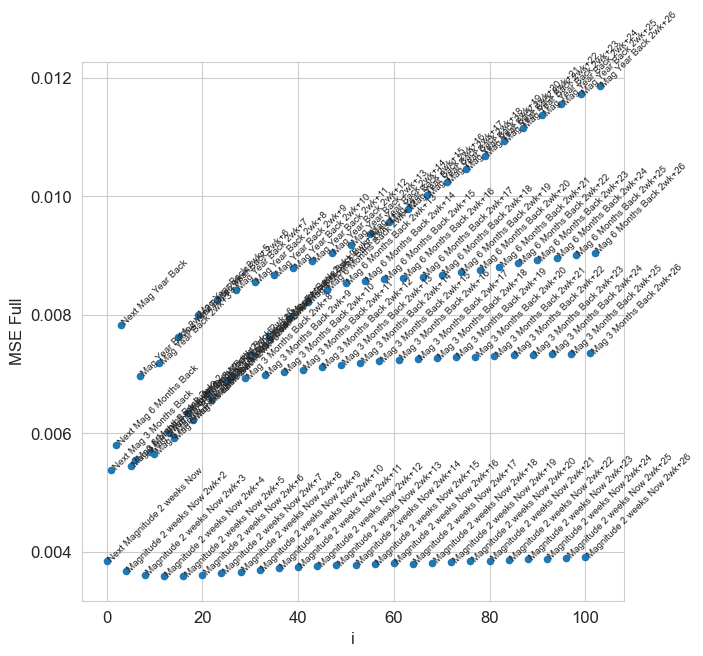

In [19]:
ax = df_mse.plot(x='i', y='MSE Full', kind='scatter', figsize=(7,7))
df_mse[['i', 'MSE Full', 'name']].apply(lambda x: ax.text(*x, rotation=45, fontsize=7),axis=1)
# add a new color for each line
# if '2 weeks now' in name, make it a certain color

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
0,Next Magnitude 2 weeks Now,0,87.88,122.78,49.22,0.003839,0.003048,0.004780,47.01%,0,Now
4,Magnitude 2 weeks Now 2wk+2,4,85.84,112.55,45.42,0.003669,0.002936,0.004543,43.23%,1,2wk+2
8,Magnitude 2 weeks Now 2wk+3,8,85.06,108.80,43.05,0.003607,0.002905,0.004445,40.87%,2,2wk+3
12,Magnitude 2 weeks Now 2wk+4,12,84.74,107.90,40.95,0.003583,0.002901,0.004398,39.05%,3,2wk+4
16,Magnitude 2 weeks Now 2wk+5,16,84.74,107.92,39.72,0.003586,0.002914,0.004390,38.13%,4,2wk+5
20,Magnitude 2 weeks Now 2wk+6,20,84.96,108.55,39.51,0.003606,0.002942,0.004402,38.01%,5,2wk+6
24,Magnitude 2 weeks Now 2wk+7,24,85.28,110.06,39.25,0.003634,0.002973,0.004427,37.97%,6,2wk+7
28,Magnitude 2 weeks Now 2wk+8,28,85.58,111.22,39.28,0.003661,0.002999,0.004457,38.19%,7,2wk+8
32,Magnitude 2 weeks Now 2wk+9,32,85.87,111.96,39.76,0.003688,0.003024,0.004487,38.75%,8,2wk+9
36,Magnitude 2 weeks Now 2wk+10,36,86.21,113.07,40.67,0.003718,0.003051,0.004520,39.67%,9,2wk+10


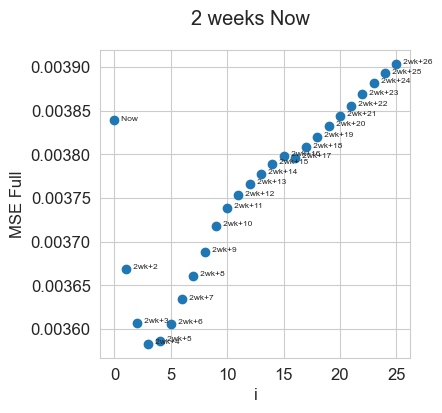

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
1,Next Mag 3 Months Back,1,64.55,71.19,22.67,0.005381,0.005797,0.004886,21.97%,0,Back
5,Mag 3 Months Back 2wk+2,5,64.91,69.76,22.38,0.005444,0.005837,0.004976,21.7%,1,2wk+2
9,Mag 3 Months Back 2wk+3,9,66.30,70.62,22.53,0.005683,0.006045,0.005250,21.81%,2,2wk+3
13,Mag 3 Months Back 2wk+4,13,68.14,73.02,22.50,0.006008,0.006348,0.005601,21.85%,3,2wk+4
17,Mag 3 Months Back 2wk+5,17,69.98,75.67,22.50,0.006343,0.006669,0.005952,21.93%,4,2wk+5
21,Mag 3 Months Back 2wk+6,21,71.70,78.19,22.87,0.006664,0.006988,0.006277,22.21%,5,2wk+6
25,Mag 3 Months Back 2wk+7,25,72.73,79.52,23.73,0.006861,0.007180,0.006479,22.89%,6,2wk+7
29,Mag 3 Months Back 2wk+8,29,73.04,79.60,24.63,0.006923,0.007233,0.006550,23.71%,7,2wk+8
33,Mag 3 Months Back 2wk+9,33,73.30,79.61,25.35,0.006975,0.007281,0.006606,24.4%,8,2wk+9
37,Mag 3 Months Back 2wk+10,37,73.53,79.64,25.90,0.007023,0.007328,0.006655,24.98%,9,2wk+10


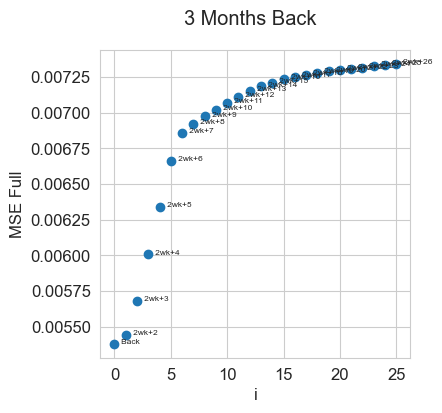

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
2,Next Mag 6 Months Back,2,58.29,61.35,19.95,0.005805,0.006474,0.005009,20.1%,0,Back
6,Mag 6 Months Back 2wk+2,6,56.96,59.24,18.12,0.005538,0.006189,0.004762,18.69%,1,2wk+2
10,Mag 6 Months Back 2wk+3,10,57.55,59.23,18.09,0.005653,0.006297,0.004884,18.83%,2,2wk+3
14,Mag 6 Months Back 2wk+4,14,58.83,60.30,18.41,0.005910,0.006552,0.005142,19.16%,3,2wk+4
18,Mag 6 Months Back 2wk+5,18,60.36,61.89,18.74,0.006228,0.006872,0.005458,19.39%,4,2wk+5
22,Mag 6 Months Back 2wk+6,22,61.98,63.88,18.97,0.006576,0.007231,0.005791,19.51%,5,2wk+6
26,Mag 6 Months Back 2wk+7,26,63.62,66.18,19.06,0.006939,0.007617,0.006126,19.52%,6,2wk+7
30,Mag 6 Months Back 2wk+8,30,65.21,68.56,19.02,0.007299,0.008000,0.006457,19.51%,7,2wk+8
34,Mag 6 Months Back 2wk+9,34,66.68,70.80,19.01,0.007641,0.008362,0.006772,19.55%,8,2wk+9
38,Mag 6 Months Back 2wk+10,38,67.97,72.72,19.13,0.007948,0.008686,0.007058,19.7%,9,2wk+10


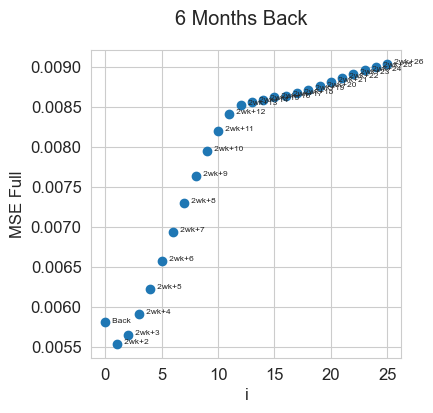

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df['index'] = range(0, len(generated_df))
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1491306900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]


,name,i,IndE^2/IndObs^2,IndE/IndObs,summedErr/SummedObs,MSE Full,MSE Start,MSE End,MSE Total,index,2weekIntervals
3,Next Mag Year Back,3,58.17,62.45,19.33,0.007831,0.008627,0.006883,20.45%,0,Back
7,Mag Year Back 2wk+2,7,54.91,55.80,20.01,0.006966,0.007654,0.006146,20.66%,1,2wk+2
11,Mag Year Back 2wk+3,11,55.86,54.03,21.55,0.007178,0.007610,0.006662,22.16%,2,2wk+3
15,Mag Year Back 2wk+4,15,57.64,54.07,22.67,0.007620,0.007820,0.007381,23.56%,3,2wk+4
19,Mag Year Back 2wk+5,19,59.08,54.80,23.25,0.007992,0.008086,0.007880,24.43%,4,2wk+5
23,Mag Year Back 2wk+6,23,59.98,55.75,23.54,0.008240,0.008358,0.008099,24.84%,5,2wk+6
27,Mag Year Back 2wk+7,27,60.60,56.72,23.64,0.008419,0.008635,0.008160,24.95%,6,2wk+7
31,Mag Year Back 2wk+8,31,61.01,57.65,23.60,0.008549,0.008896,0.008132,24.86%,7,2wk+8
35,Mag Year Back 2wk+9,35,61.35,58.60,23.56,0.008665,0.009136,0.008097,24.71%,8,2wk+9
39,Mag Year Back 2wk+10,39,61.71,59.48,23.51,0.008783,0.009339,0.008112,24.51%,9,2wk+10


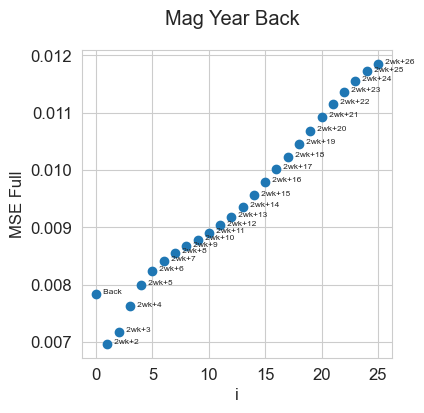

In [20]:
dataframe_dict = {}
mse_list = ['2 weeks Now', '3 Months Back', '6 Months Back', 'Mag Year Back']
for mse in mse_list:
    generated_df = df_mse[df_mse['name'].str.contains(mse)]
    generated_df['index'] = range(0, len(generated_df))
    for index, row in generated_df.iterrows():
        generated_df.loc[index, '2weekIntervals'] = generated_df.loc[index, 'name'].split()[-1]
    display(generated_df)
    dataframe_dict[mse] = generated_df
    fig, ax = plt.subplots()
    ax.scatter(x=generated_df['index'], y=generated_df['MSE Full'])
    fig.set_size_inches(4,4)
    fig.suptitle(mse)
    plt.xlabel('i')
    plt.ylabel('MSE Full')
    # generated_df.plot(x='i', y='MSE Full', kind='scatter', figsize=(4,4), title=mse)
    for idx, row in generated_df.iterrows():
        ax.annotate('   ' + row['2weekIntervals'], (row['index'], row['MSE Full']), rotation=0, fontsize=6)
    plt.show()
    # dataframe_list.append(generated_df)

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2441612804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


2-weeks-now


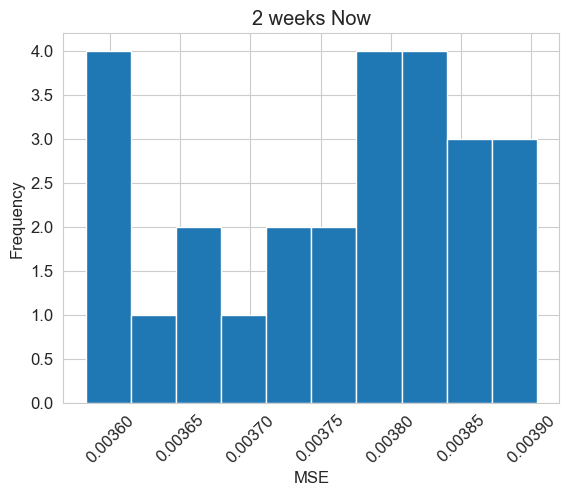

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2441612804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


3-months-back


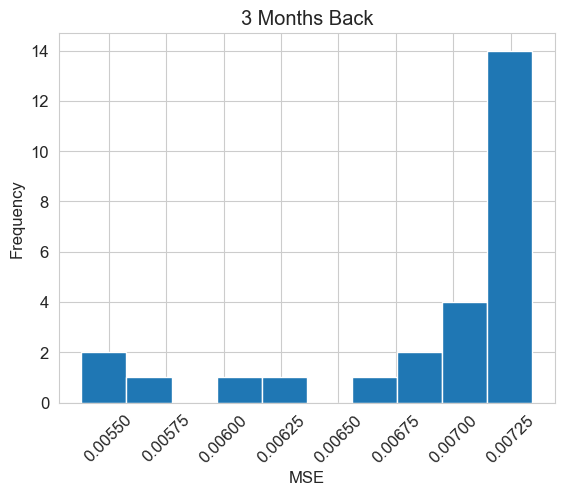

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2441612804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


6-months-back


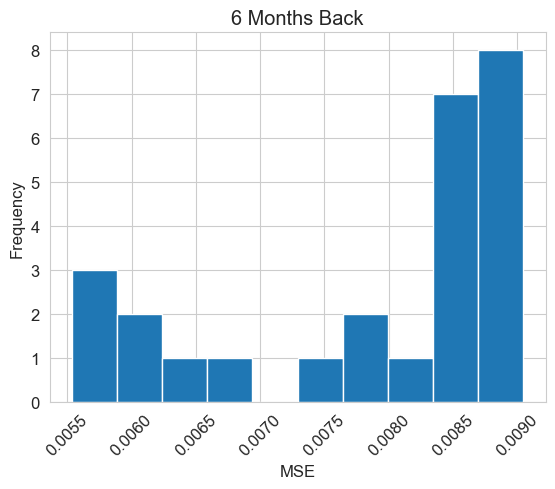

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2441612804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'MSE Full': 'MSE'}, inplace=True)


mag-year-back


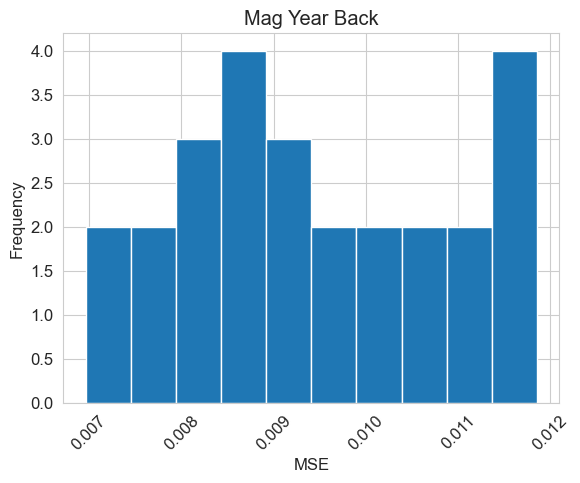

In [21]:


for key, df in dataframe_dict.items():
    df.rename(columns={'MSE Full': 'MSE'}, inplace=True)
    df.hist(column='MSE')
    plt.title(key)
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    temp_key = key.replace(' ', '-').lower()
    print(temp_key)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    plt.tick_params(axis='x', rotation=45)
    image_file = Shell.map_filename(f'./images/{temp_key}-MSE.pdf').path
    plt.savefig(image_file)
    plt.show()


In [22]:
# fig, ax = plt.subplots()
# ax.scatter(x=df_mse['i'],y=df_mse['MSE Full'],c='DarkBlue')
# ax.set_xlabel('i')
# ax.set_ylabel('MSE Full')

In [23]:
# df_mse.reset_index().plot.scatter(x='index', y='MSE Full', ax=ax)

In [24]:
# for i, txt in enumerate(df_mse.result):
#     ax.annotate(txt, (df_mse['i'].iat[i], df_mse['MSE Full'].iat[i]))

In [25]:
# plt.show()

In [26]:
from pprint import pprint
verbose = False

dict_of_log = {}

epochs = ["2","30","70"]

for epoch in epochs:
    dict_of_log[epoch] = Shell.map_filename(
        f'../experiments/rivanna/localscratch/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB' \
        f'_repeat_1_TFTTransformerepochs_{epoch}/cloudmesh_mllog.log').path

mynotebooks = {}

for key, value in dict_of_log.items():
    temp_readfile = readfile(value)
    if verbose:
        print(temp_readfile[:300])
    mynotebooks[key] = temp_readfile

count_lines = 0
dict_of_lines = {}
for epoch in epochs:
    dict_of_lines[epoch] = []

for key, value in list(mynotebooks.items()):
    for line in value.splitlines():
        #line.replace('\\', '')
        if 'F=' in line and 'S=' in line and 'E=' in line and 'NNSE' in line:
            dict_of_lines[key].append(line)

            count_lines += 1
            if verbose:
                print(line)

if verbose:
    print(count_lines)

In [27]:
print(len(dict_of_lines['2']))
print(len(dict_of_lines['30']))
print(len(dict_of_lines['70']))
# print(dict_of_lines['2'])


32
32
32


In [28]:

# pprint(fixed_dicts)
# print(len(dict_of_lines.values()))
dict_of_epochs = {}
for key, value in dict_of_lines.items():
    # print(len(value))
    # print(key)
    for iterated_line in value:
        # print(iterated_line)
        working_line = iterated_line.strip()
        # print(type(working_line))
        # print(working_line)
        working_line = working_line.replace(':::MLLOG ', '')
        # print('a', working_line)
        working_line = working_line[:-3]
        # print('b', working_line)
        working_line = working_line.replace('\\', '')
        # print('c', working_line)
        working_line = working_line.split(', "metadata":', 1)[0]
        working_line += '}'
        working_line = eval(working_line)
        working_line['value'] = eval(working_line['value'])
        # print('d', working_line)
        # print(type(working_line))

        # interpreting scientific values
        parse_line = working_line['value']['extrastring']
        parse_list = parse_line.split()

        # this function returns the value after a specified word
        def looking_for(seeking_value: str):
            found_it = False
            for word in parse_list:
                if found_it:
                    return word
                if word == seeking_value:
                    found_it = True
                    continue

        validation_value = looking_for('Validation')
        if validation_value:
            working_line['value']['validation'] = validation_value
        training_value = looking_for('Training')
        if training_value:
            working_line['value']['training'] = training_value

        list_of_values = []
        working_line['value']['MSE'] = {}
        for word in parse_list:
            if '=' in word and ('F' in word or 'S' in word or 'E' in word):
                temp_word = word.split('=')
                working_line['value']['MSE'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AV:' in word or 'S:' in word or 'SV:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
            elif 'A:' in word or 'AT:' in word or 'S:' in word or 'ST:' in word:
                temp_word = word.split(':')
                working_line['value'][temp_word[0]] = temp_word[1]
        working_line['value']['title'] = working_line['key']
        working_line['key'] = 'result'

        program_title = looking_for('UTC')
        working_line['value']['program'] = program_title
        nnse = looking_for('summedErr/SummedObs')
        working_line['value']['NNSE'] = nnse
        comment = looking_for('TOTAL')
        working_line['value']['comment'] = comment

        future = re.search('FUTURE (.*) MSE', working_line['value']['extrastring'])
        try:
            working_line['value']['future'] = future.group(1)
        except AttributeError:
            pass

        loc_sum = re.search('Location Summed Results (.*),', working_line['value']['extrastring'])
        working_line['value']['location_summed_results'] = loc_sum.group(1)
        del working_line['value']['extrastring']
        # pprint(working_line)

        try:
            if not dict_of_epochs[key]:
                dict_of_epochs[key] = []
        except KeyError:
            dict_of_epochs[key] = []

        dict_of_epochs[key].append(working_line)
        # fixed_dicts[key].append(working_line)


In [29]:
if verbose:

    pprint(dict_of_epochs)
        # print(working_line)
print(dict_of_epochs.keys())

print(type(dict_of_epochs['2']))
print(type(dict_of_epochs['2'][0]))
print(len(dict_of_epochs['2']))
print(len(dict_of_epochs['30']))
print(len(dict_of_epochs['70']))

dict_keys(['2', '30', '70'])
<class 'list'>
<class 'dict'>
32
32
32


In [30]:
# dict_of_dataframes = dict.fromkeys(dict_of_lines.keys(), [])
dict_of_dataframes = {}
for epoch in epochs:
    try:
        if not dict_of_dataframes[f'{epoch}_training']:
            dict_of_dataframes[f'{epoch}_training'] = None
    except KeyError:
        dict_of_dataframes[f'{epoch}_training'] = None
        # dict_of_epochs[key].append(working_line)
    try:
        if not dict_of_dataframes[f'{epoch}_validation']:
            dict_of_dataframes[f'{epoch}_validation'] = None
    except KeyError:
        dict_of_dataframes[f'{epoch}_validation'] = None
        # dict_of_epochs[key].append(working_line)

for key, value in dict_of_epochs.items():
    list_of_value_dicts_training = []
    list_of_value_dicts_validation = []
    fails = 0
    for dictionary in value:
        # try:
        #     if dictionary['value']['training']:
        #         list_of_value_dicts_training.append(dictionary['value'])
        # except KeyError:
        #     list_of_value_dicts_validation.append(dictionary['value'])
        if dictionary.get('value', None).get('training', None):
            list_of_value_dicts_training.append(dictionary['value'])
        elif dictionary.get('value', None).get('validation', None):
            list_of_value_dicts_validation.append(dictionary['value'])
        else:
            fails += 1
    print('fails:', fails)
        #list_of_value_dicts.append(dictionary['value'])

    for iterated_dictionary in list_of_value_dicts_training:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    for iterated_dictionary in list_of_value_dicts_validation:
        temp_mse = iterated_dictionary['MSE']
        iterated_dictionary['MSE_F'] = temp_mse['F']
        iterated_dictionary['MSE_S'] = temp_mse['S']
        iterated_dictionary['MSE_E'] = temp_mse['E']

    df_training = pd.DataFrame(list_of_value_dicts_training)
    df_validation = pd.DataFrame(list_of_value_dicts_validation)

    df_training.drop('MSE', axis=1, inplace=True)
    df_validation.drop('MSE', axis=1, inplace=True)

    df_training.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)
    df_validation.rename(columns={'NNSE': 'NNSEpercent', 'MSE_F': 'MSE'}, inplace=True)

    dataframes = [df_training, df_validation]

    for dataframe in dataframes:
        for index, row in dataframe.iterrows():
            dataframe.loc[index, 'NNSE'] = float(dataframe.loc[index, 'NNSEpercent'].strip('%')) / 100.0

            if dataframe.loc[index, 'future'] is np.nan:
                temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
                remove_words = ['Magnitude', 'Mag']
                for word in remove_words:
                    if word in temp_string_list:
                        temp_string_list.remove(word)
                new_string = " ".join(temp_string_list)
                dataframe.loc[index, 'name'] = new_string

            else:
                added_string = ''
                temp_string_list = dataframe.loc[index, 'location_summed_results'].split()
                if 'Months' in temp_string_list:
                    if '6' in temp_string_list:
                        added_string = '6M '
                    elif '3' in temp_string_list:
                        added_string = '3M '
                elif 'Year' in temp_string_list:
                    added_string = '1Y '
                elif '2' in temp_string_list and 'weeks' in temp_string_list and 'Now' in temp_string_list:
                    added_string = 'Now '
                dataframe.loc[index, 'name'] = added_string + dataframe.loc[index, 'future'].split()[-1]
        dataframe.sort_values('NNSE', inplace=True)

        dataframe.pop("NNSEpercent")
        last = len(df_training.keys()) -1
        DELETE = -1000

        for index, what in [(0, 'name'),
                            (1,"NNSE"),
                            (DELETE, "location_summed_results"),
                            (DELETE, "comment"),
                            (DELETE, "title"),
                            (DELETE, "program")]:
            col = dataframe.pop(what)
            if index != DELETE:
                dataframe.insert(index, what, col)

    display(df_training)
    dict_of_dataframes[f'{key}_training'] = df_training
    display(df_validation)
    dict_of_dataframes[f'{key}_validation'] = df_validation

fails: 0


,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
3,Year Back,0.1913,0.72242,0.582,NaN,0.614,NaN,0.007831,0.008627,0.006883,0.587,0.636,NaN
6,6M 2wk+7AVG,0.1927,0.72242,0.582,0.581,0.614,0.607,0.006939,0.007617,0.006126,NaN,NaN,Mag 6 Months Back 2wk+7AVG
10,6M 2wk+13AVG,0.1970,0.72242,0.582,0.581,0.614,0.607,0.008528,0.009321,0.007569,NaN,NaN,Mag 6 Months Back 2wk+13AVG
2,6 Months Back,0.2016,0.72242,0.582,0.581,0.614,0.607,0.005805,0.006474,0.005009,NaN,NaN,NaN
11,1Y 2wk+13AVG,0.2326,0.72242,0.582,NaN,0.614,NaN,0.009178,0.01006,0.008111,0.587,0.636,Mag Year Back 2wk+13AVG
1,3 Months Back,0.2330,0.72242,0.481,NaN,0.313,NaN,0.005381,0.005797,0.004886,0.484,0.375,NaN
7,1Y 2wk+7AVG,0.2358,0.72242,0.582,NaN,0.614,NaN,0.008419,0.008635,0.00816,0.587,0.636,Mag Year Back 2wk+7AVG
5,3M 2wk+7AVG,0.2430,0.72242,0.481,NaN,0.313,NaN,0.006861,0.00718,0.006479,0.484,0.375,Mag 3 Months Back 2wk+7AVG
15,1Y 2wk+26AVG,0.2516,0.72242,0.582,NaN,0.614,NaN,0.011856,0.012663,0.010864,0.587,0.636,Mag Year Back 2wk+26AVG
14,6M 2wk+26AVG,0.2517,0.72242,0.582,0.581,0.614,0.607,0.009043,0.009572,0.008392,NaN,NaN,Mag 6 Months Back 2wk+26AVG


,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
6,6M 2wk+7AVG,0.1952,0.74745,0.582,0.581,0.614,0.607,0.007081,0.007894,0.006105,NaN,NaN,Mag 6 Months Back 2wk+7AVG
2,6 Months Back,0.2010,0.74745,0.582,0.581,0.614,0.607,0.005979,0.006831,0.004965,NaN,NaN,NaN
10,6M 2wk+13AVG,0.2016,0.74745,0.582,0.581,0.614,0.607,0.008521,0.009567,0.007255,NaN,NaN,Mag 6 Months Back 2wk+13AVG
3,Year Back,0.2045,0.74745,0.582,NaN,0.614,NaN,0.008337,0.009206,0.007302,0.587,0.636,NaN
1,3 Months Back,0.2197,0.74745,0.481,NaN,0.313,NaN,0.005441,0.006075,0.004686,0.484,0.375,NaN
5,3M 2wk+7AVG,0.2289,0.74745,0.481,NaN,0.313,NaN,0.006845,0.007471,0.006093,0.484,0.375,Mag 3 Months Back 2wk+7AVG
11,1Y 2wk+13AVG,0.2382,0.74745,0.582,NaN,0.614,NaN,0.009752,0.010536,0.008805,0.587,0.636,Mag Year Back 2wk+13AVG
7,1Y 2wk+7AVG,0.2495,0.74745,0.582,NaN,0.614,NaN,0.009429,0.009297,0.009587,0.587,0.636,Mag Year Back 2wk+7AVG
14,6M 2wk+26AVG,0.2644,0.74745,0.582,0.581,0.614,0.607,0.009138,0.0098,0.008325,NaN,NaN,Mag 6 Months Back 2wk+26AVG
9,3M 2wk+13AVG,0.2662,0.74745,0.481,NaN,0.313,NaN,0.007138,0.007723,0.006431,0.484,0.375,Mag 3 Months Back 2wk+13AVG


fails: 0


,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
3,Year Back,0.0476,0.59831,0.813,NaN,0.891,NaN,0.001172,0.001398,0.000902,0.816,0.894,NaN
2,6 Months Back,0.0695,0.59831,0.813,0.812,0.891,0.887,0.001314,0.001477,0.00112,NaN,NaN,NaN
7,1Y 2wk+7AVG,0.0829,0.59831,0.813,NaN,0.891,NaN,0.00291,0.003397,0.002325,0.816,0.894,Mag Year Back 2wk+7AVG
1,3 Months Back,0.0897,0.59831,0.521,NaN,0.52,NaN,0.001696,0.001839,0.001525,0.526,0.606,NaN
11,1Y 2wk+13AVG,0.1716,0.59831,0.813,NaN,0.891,NaN,0.00539,0.006283,0.00431,0.816,0.894,Mag Year Back 2wk+13AVG
6,6M 2wk+7AVG,0.2081,0.59831,0.813,0.812,0.891,0.887,0.004772,0.005334,0.004099,NaN,NaN,Mag 6 Months Back 2wk+7AVG
15,1Y 2wk+26AVG,0.3196,0.59831,0.813,NaN,0.891,NaN,0.011329,0.01319,0.009041,0.816,0.894,Mag Year Back 2wk+26AVG
5,3M 2wk+7AVG,0.3303,0.59831,0.521,NaN,0.52,NaN,0.007084,0.007479,0.006608,0.526,0.606,Mag 3 Months Back 2wk+7AVG
10,6M 2wk+13AVG,0.3418,0.59831,0.813,0.812,0.891,0.887,0.008914,0.009951,0.00766,NaN,NaN,Mag 6 Months Back 2wk+13AVG
9,3M 2wk+13AVG,0.3946,0.59831,0.521,NaN,0.52,NaN,0.007394,0.007714,0.007007,0.526,0.606,Mag 3 Months Back 2wk+13AVG


,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
3,Year Back,0.0505,0.59355,0.813,NaN,0.891,NaN,0.00122,0.001439,0.000959,0.816,0.894,NaN
2,6 Months Back,0.0703,0.59355,0.813,0.812,0.891,0.887,0.001328,0.001521,0.001099,NaN,NaN,NaN
7,1Y 2wk+7AVG,0.0765,0.59355,0.813,NaN,0.891,NaN,0.002899,0.003401,0.002297,0.816,0.894,Mag Year Back 2wk+7AVG
1,3 Months Back,0.0904,0.59355,0.521,NaN,0.52,NaN,0.001718,0.001917,0.001481,0.526,0.606,NaN
11,1Y 2wk+13AVG,0.1536,0.59355,0.813,NaN,0.891,NaN,0.005315,0.006272,0.004159,0.816,0.894,Mag Year Back 2wk+13AVG
6,6M 2wk+7AVG,0.1862,0.59355,0.813,0.812,0.891,0.887,0.004699,0.005409,0.003848,NaN,NaN,Mag 6 Months Back 2wk+7AVG
15,1Y 2wk+26AVG,0.2901,0.59355,0.813,NaN,0.891,NaN,0.011106,0.01306,0.008703,0.816,0.894,Mag Year Back 2wk+26AVG
5,3M 2wk+7AVG,0.2919,0.59355,0.521,NaN,0.52,NaN,0.006948,0.007686,0.006062,0.526,0.606,Mag 3 Months Back 2wk+7AVG
10,6M 2wk+13AVG,0.3028,0.59355,0.813,0.812,0.891,0.887,0.008706,0.010054,0.007077,NaN,NaN,Mag 6 Months Back 2wk+13AVG
9,3M 2wk+13AVG,0.3434,0.59355,0.521,NaN,0.52,NaN,0.007218,0.007868,0.006432,0.526,0.606,Mag 3 Months Back 2wk+13AVG


fails: 0


,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
1,3 Months Back,0.0674,0.58488,0.511,NaN,0.435,NaN,0.001448,0.00158,0.001292,0.517,0.531,NaN
3,Year Back,0.0735,0.58488,0.832,NaN,0.894,NaN,0.000825,0.000997,0.000619,0.835,0.899,NaN
7,1Y 2wk+7AVG,0.0831,0.58488,0.832,NaN,0.894,NaN,0.002816,0.003281,0.002257,0.835,0.899,Mag Year Back 2wk+7AVG
2,6 Months Back,0.1053,0.58488,0.832,0.831,0.894,0.89,0.001049,0.00117,0.000906,NaN,NaN,NaN
6,6M 2wk+7AVG,0.1384,0.58488,0.832,0.831,0.894,0.89,0.004433,0.004973,0.003785,NaN,NaN,Mag 6 Months Back 2wk+7AVG
11,1Y 2wk+13AVG,0.1535,0.58488,0.832,NaN,0.894,NaN,0.005282,0.006122,0.004267,0.835,0.899,Mag Year Back 2wk+13AVG
10,6M 2wk+13AVG,0.2521,0.58488,0.832,0.831,0.894,0.89,0.00841,0.009407,0.007204,NaN,NaN,Mag 6 Months Back 2wk+13AVG
14,6M 2wk+26AVG,0.2959,0.58488,0.832,0.831,0.894,0.89,0.008859,0.009673,0.007858,NaN,NaN,Mag 6 Months Back 2wk+26AVG
15,1Y 2wk+26AVG,0.3188,0.58488,0.832,NaN,0.894,NaN,0.011241,0.013133,0.008914,0.835,0.899,Mag Year Back 2wk+26AVG
5,3M 2wk+7AVG,0.3354,0.58488,0.511,NaN,0.435,NaN,0.007028,0.00743,0.006545,0.517,0.531,Mag 3 Months Back 2wk+7AVG


,name,NNSE,validation,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future
1,3 Months Back,0.0698,0.58062,0.511,NaN,0.435,NaN,0.001444,0.001635,0.001217,0.517,0.531,NaN
3,Year Back,0.0712,0.58062,0.832,NaN,0.894,NaN,0.000846,0.001022,0.000636,0.835,0.899,NaN
7,1Y 2wk+7AVG,0.0843,0.58062,0.832,NaN,0.894,NaN,0.002798,0.00328,0.00222,0.835,0.899,Mag Year Back 2wk+7AVG
2,6 Months Back,0.1022,0.58062,0.832,0.831,0.894,0.89,0.001048,0.001192,0.000877,NaN,NaN,NaN
6,6M 2wk+7AVG,0.1337,0.58062,0.832,0.831,0.894,0.89,0.004364,0.005037,0.003555,NaN,NaN,Mag 6 Months Back 2wk+7AVG
11,1Y 2wk+13AVG,0.1428,0.58062,0.832,NaN,0.894,NaN,0.005206,0.006095,0.004131,0.835,0.899,Mag Year Back 2wk+13AVG
10,6M 2wk+13AVG,0.2354,0.58062,0.832,0.831,0.894,0.89,0.008241,0.009511,0.006706,NaN,NaN,Mag 6 Months Back 2wk+13AVG
14,6M 2wk+26AVG,0.2697,0.58062,0.832,0.831,0.894,0.89,0.008577,0.009593,0.007328,NaN,NaN,Mag 6 Months Back 2wk+26AVG
5,3M 2wk+7AVG,0.2911,0.58062,0.511,NaN,0.435,NaN,0.006901,0.00763,0.006026,0.517,0.531,Mag 3 Months Back 2wk+7AVG
15,1Y 2wk+26AVG,0.2935,0.58062,0.832,NaN,0.894,NaN,0.011039,0.013003,0.008626,0.835,0.899,Mag Year Back 2wk+26AVG


In [31]:
for key, value in dict_of_dataframes.items():
    print(len(value))
    print(key)
    epoch = key.split('_')[0]
    training_or_validation = key.split('_')[1]
    value['epoch'] = epoch
    value['epoch'] = value['epoch'].astype(float)
    print('epoch:', epoch)

    value['type of run'] = training_or_validation
    print('type of run:', training_or_validation)

16
2_training
epoch: 2
type of run: training
16
2_validation
epoch: 2
type of run: validation
16
30_training
epoch: 30
type of run: training
16
30_validation
epoch: 30
type of run: validation
16
70_training
epoch: 70
type of run: training
16
70_validation
epoch: 70
type of run: validation


dict_keys(['2_training', '2_validation', '30_training', '30_validation', '70_training', '70_validation'])


<Figure size 640x480 with 0 Axes>

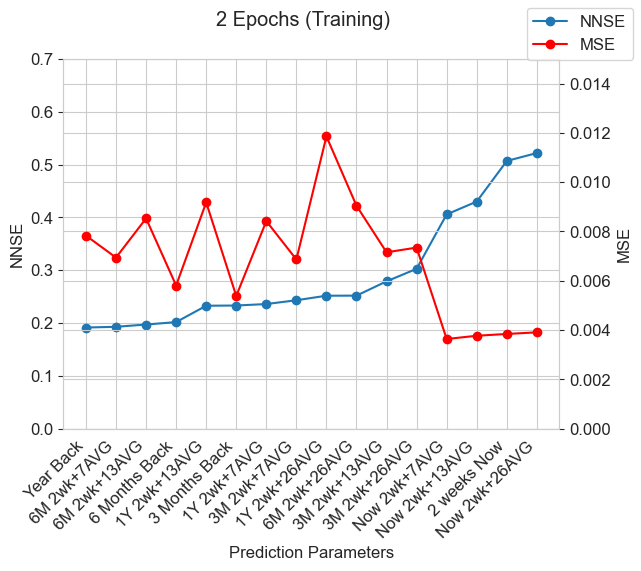

<Figure size 640x480 with 0 Axes>

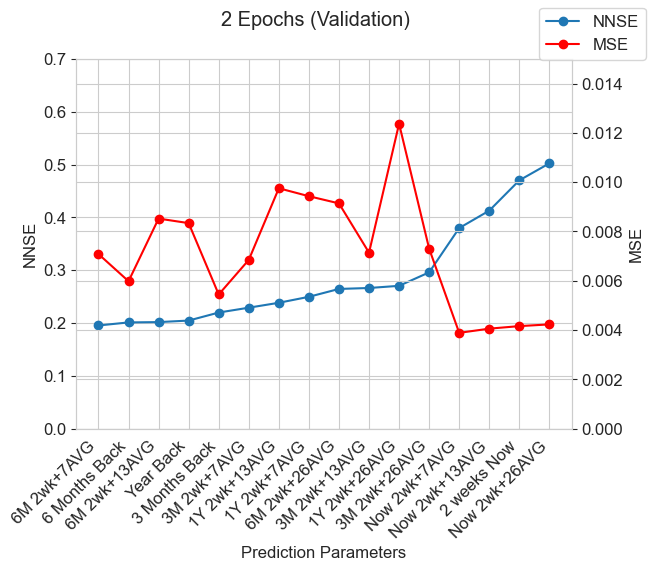

<Figure size 640x480 with 0 Axes>

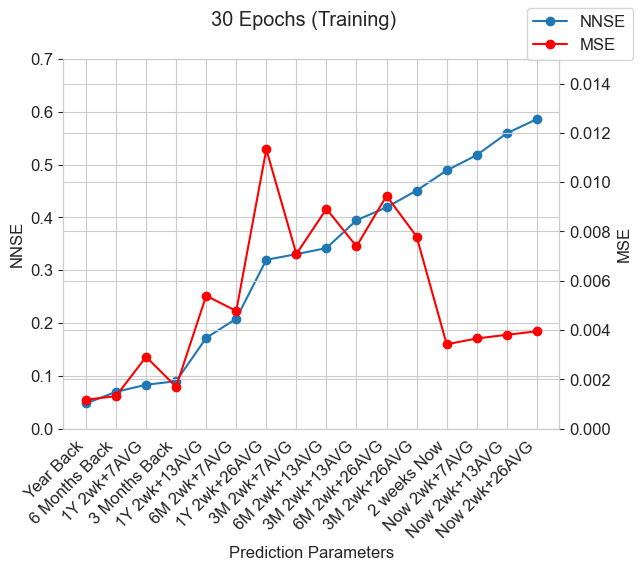

<Figure size 640x480 with 0 Axes>

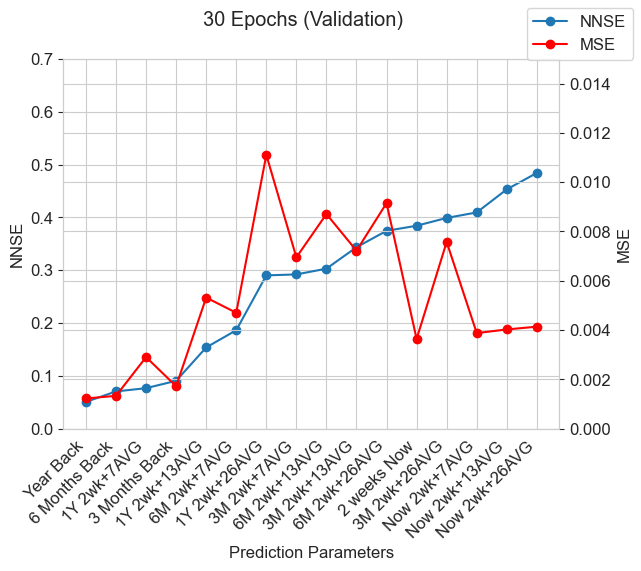

<Figure size 640x480 with 0 Axes>

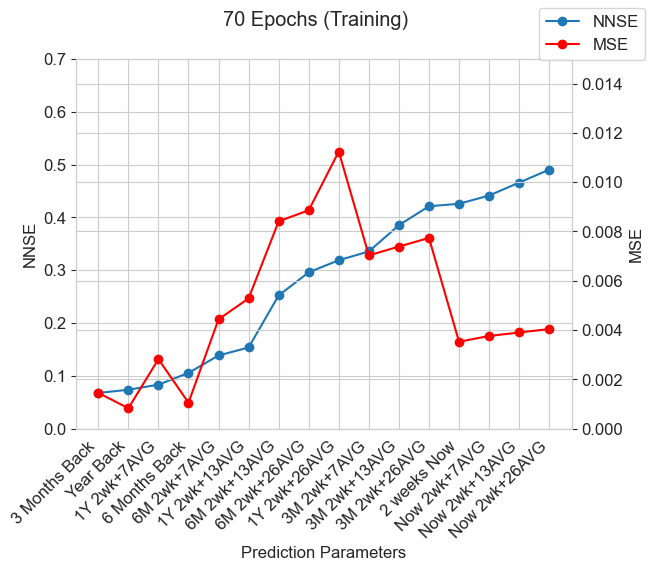

<Figure size 640x480 with 0 Axes>

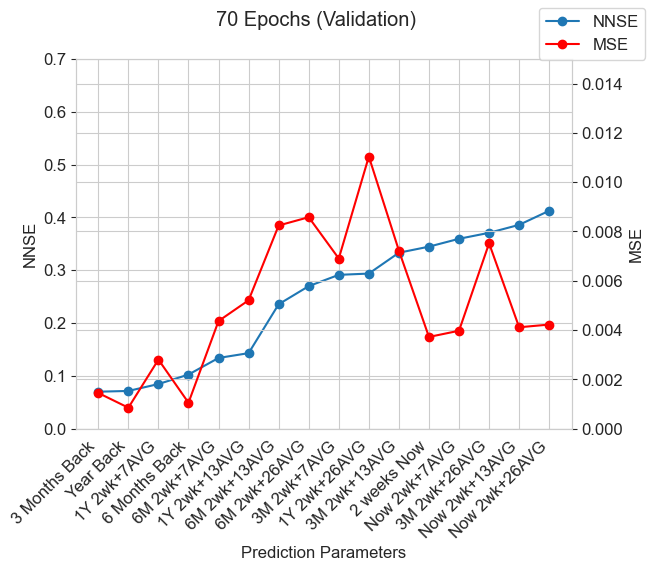

In [32]:
print(dict_of_dataframes.keys())
for key, value in dict_of_dataframes.items():
    plt.clf()
    value['MSE'] = value['MSE'].astype(float)
    value['index'] = range(0, len(value))
    ax = value.plot(x='name', y='NNSE', marker="o", legend=False, ylim=[0, 0.7])
    ax1 = ax.twinx()
    value.plot(x='name', y='MSE', ax=ax1, color='r', marker="o", legend=False, ylim=[0, 0.015])
    # value.plot(x="MSE_F", y='index', legend=False, color="r")
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    ax.figure.legend()
    num_epochs = key.split('_')[0]
    type_of_graph = key.split('_')[1].capitalize()
    plt.suptitle(f'{num_epochs} Epochs ({type_of_graph})')
    plt.xticks(value['index'], value['name'])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Prediction Parameters")
    ax.set_ylabel("NNSE")
    ax1.set_ylabel("MSE")

    temp_key = key.replace(' ', '-').lower()
    image_file = Shell.map_filename(f'./images/{temp_key}-MSE-and-NNSE.png').path
    image_file = Shell.map_filename(f'./images/{temp_key}-MSE-and-NNSE.pdf').path
    plt.savefig(image_file, bbox_inches='tight')
    plt.show()
    # value['sortedNNSE'] = value.groupby('NNSEdecimal', sort=True)['2weekIntervals'].rank(ascending=False)
    # value.sort_values(['sortedNNSE', '2weekIntervals'])
    # # value.sort_values(['2weekIntervals', 'NNSEdecimal'], ascending=[False, False], inplace=True)
    # plt.plot(value['NNSEdecimal'])
    # plt.xticks(range(len(value['2weekIntervals'])), value['2weekIntervals'])
    # plt.show()

dict_keys(['2_training', '2_validation', '30_training', '30_validation', '70_training', '70_validation'])
2_training


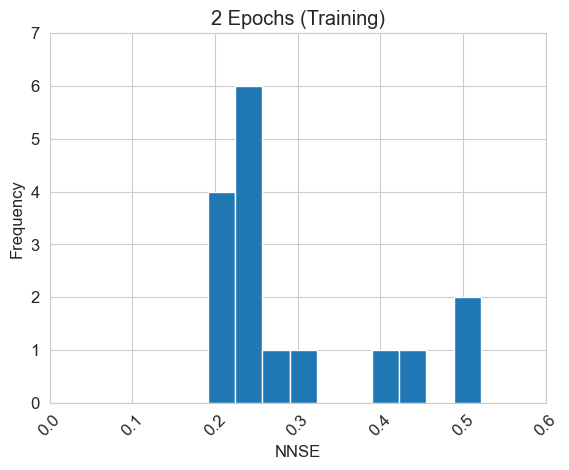

2_validation


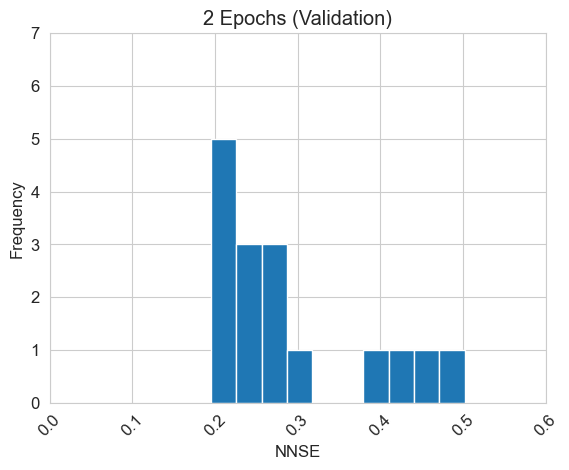

30_training


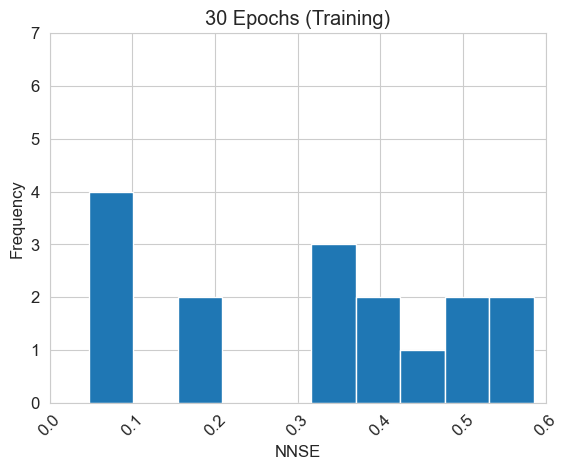

30_validation


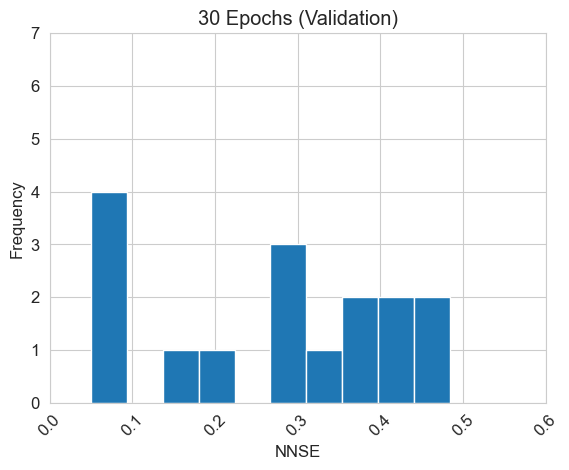

70_training


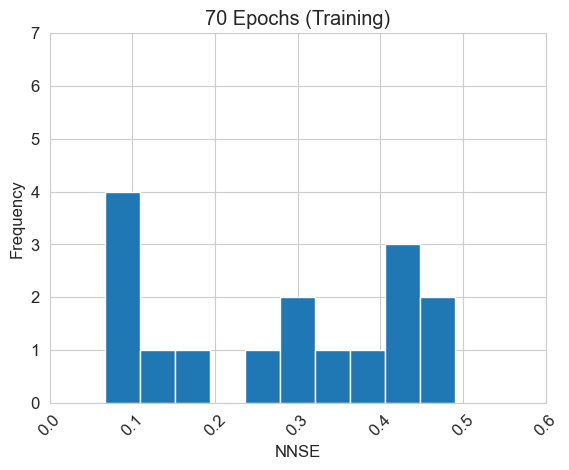

70_validation


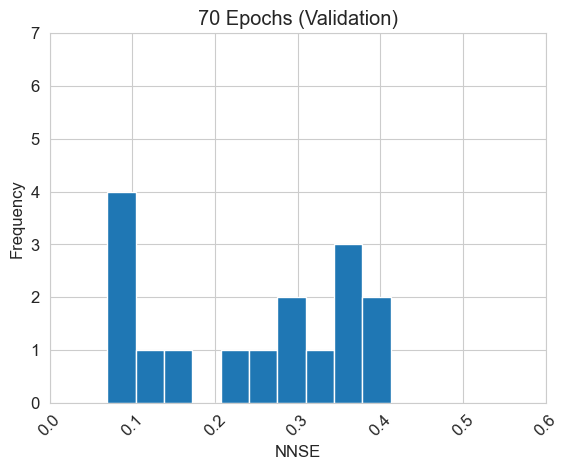

2_training


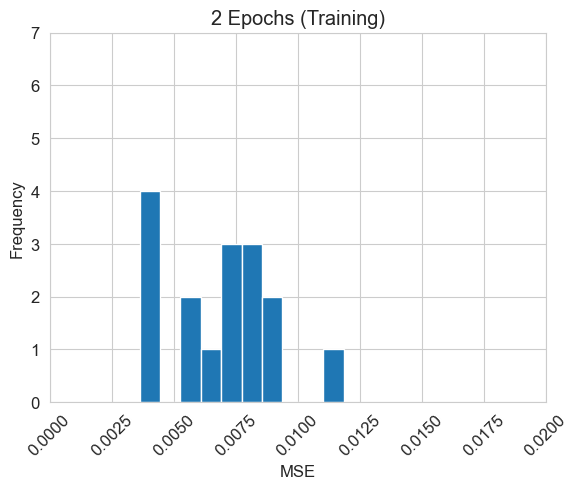

2_validation


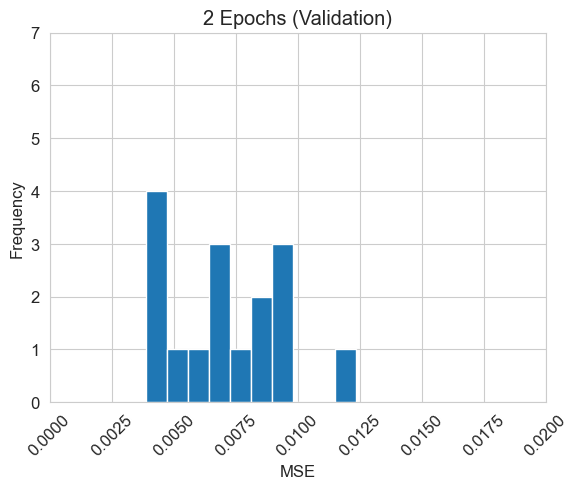

30_training


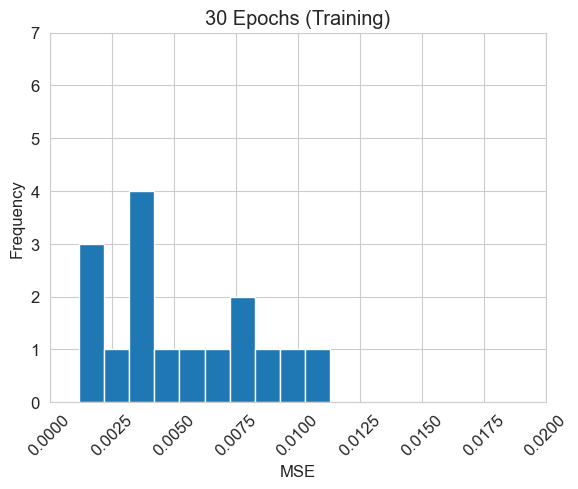

30_validation


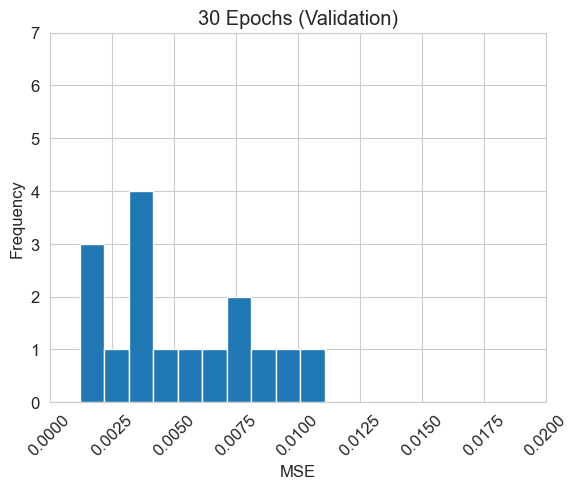

70_training


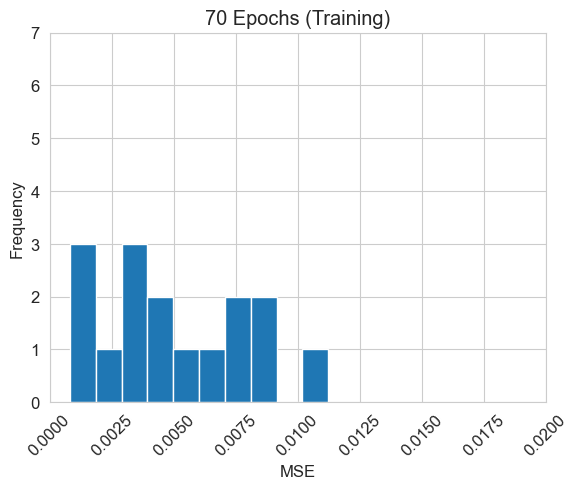

70_validation


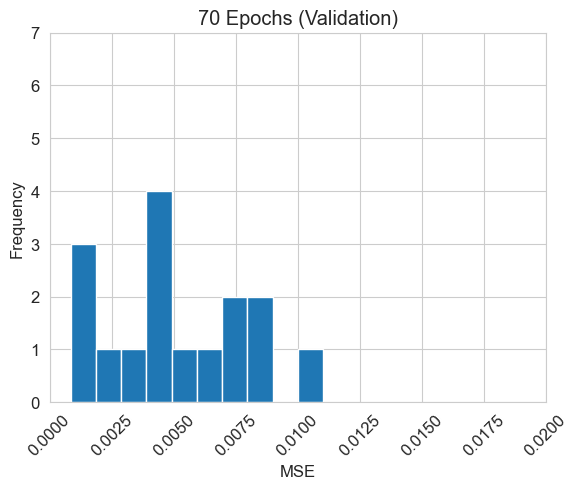

In [33]:
types_of_graphs = ['NNSE', 'MSE']
print(dict_of_dataframes.keys())
for graph in types_of_graphs:
    for key, df in dict_of_dataframes.items():
        # df.rename(columns={'MSE Full': 'MSE'}, inplace=True)
        x_lim = None
        if graph == 'NNSE':
            x_lim = [0.0, 0.6]
        else:
            x_lim = [0.0, 0.02]
        ax_list = df[graph].plot.hist(ylim=[0,7], xlim=x_lim)
        # ax_list.set_xlim(x_lim)
        # ax_list.set_ylim([0,7])
        num_epochs = key.split('_')[0]
        type_of_graph = key.split('_')[1].capitalize()
        plt.title(f'{num_epochs} Epochs ({type_of_graph})')
        plt.xlabel(graph)
        plt.ylabel('Frequency')
        temp_key = key.replace(' ', '-').lower()
        print(temp_key)
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        plt.tick_params(axis='x', rotation=45)
        image_file = Shell.map_filename(f'./images/{temp_key}-{graph}.pdf').path
        plt.savefig(image_file)
        plt.show()

In [34]:
mega_training_dataframe = pd.DataFrame()
mega_validation_dataframe = pd.DataFrame()

training_dfs = []
validation_dfs = []
for key, value in dict_of_dataframes.items():
    if 'training' in key:
        training_dfs.append(value)
    elif 'validation' in key:
        validation_dfs.append(value)
    else:
        print('fail')

mega_training_dataframe = pd.concat(training_dfs)
mega_validation_dataframe = pd.concat(validation_dfs)

In [35]:
display(mega_training_dataframe)

,name,NNSE,training,A,AT,S,ST,MSE,MSE_S,MSE_E,AV,SV,future,epoch,type of run,index
3,Year Back,0.1913,0.72242,0.582,NaN,0.614,NaN,0.007831,0.008627,0.006883,0.587,0.636,NaN,2.0,training,0
6,6M 2wk+7AVG,0.1927,0.72242,0.582,0.581,0.614,0.607,0.006939,0.007617,0.006126,NaN,NaN,Mag 6 Months Back 2wk+7AVG,2.0,training,1
10,6M 2wk+13AVG,0.1970,0.72242,0.582,0.581,0.614,0.607,0.008528,0.009321,0.007569,NaN,NaN,Mag 6 Months Back 2wk+13AVG,2.0,training,2
2,6 Months Back,0.2016,0.72242,0.582,0.581,0.614,0.607,0.005805,0.006474,0.005009,NaN,NaN,NaN,2.0,training,3
11,1Y 2wk+13AVG,0.2326,0.72242,0.582,NaN,0.614,NaN,0.009178,0.01006,0.008111,0.587,0.636,Mag Year Back 2wk+13AVG,2.0,training,4
1,3 Months Back,0.2330,0.72242,0.481,NaN,0.313,NaN,0.005381,0.005797,0.004886,0.484,0.375,NaN,2.0,training,5
7,1Y 2wk+7AVG,0.2358,0.72242,0.582,NaN,0.614,NaN,0.008419,0.008635,0.00816,0.587,0.636,Mag Year Back 2wk+7AVG,2.0,training,6
5,3M 2wk+7AVG,0.2430,0.72242,0.481,NaN,0.313,NaN,0.006861,0.00718,0.006479,0.484,0.375,Mag 3 Months Back 2wk+7AVG,2.0,training,7
15,1Y 2wk+26AVG,0.2516,0.72242,0.582,NaN,0.614,NaN,0.011856,0.012663,0.010864,0.587,0.636,Mag Year Back 2wk+26AVG,2.0,training,8
14,6M 2wk+26AVG,0.2517,0.72242,0.582,0.581,0.614,0.607,0.009043,0.009572,0.008392,NaN,NaN,Mag 6 Months Back 2wk+26AVG,2.0,training,9


C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\232415128.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


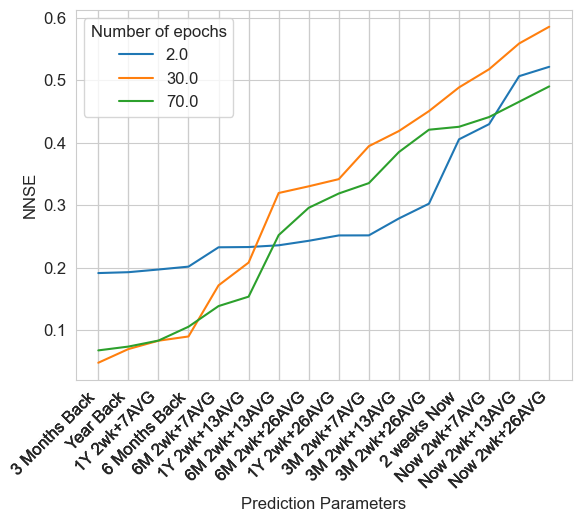

In [36]:
# df = mega_training_dataframe.pivot(index='name', columns='epoch', values='NNSE')
# df.plot(figsize=(5,3))

fig, ax = plt.subplots()
for labels, dfi in mega_training_dataframe.groupby('epoch'):
    dfi.plot(ax = ax, x = 'name', y = 'NNSE', label = labels)

ax.legend(title = 'Number of epochs')
plt.xticks(mega_training_dataframe['index'], mega_training_dataframe['name'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
         weight='light')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Prediction Parameters")
ax.set_ylabel("NNSE")
image_file = Shell.map_filename(f'./images/NNSE-all-epochs-training.pdf').path
plt.savefig(image_file, bbox_inches='tight')
fig.show()

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\3089141947.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


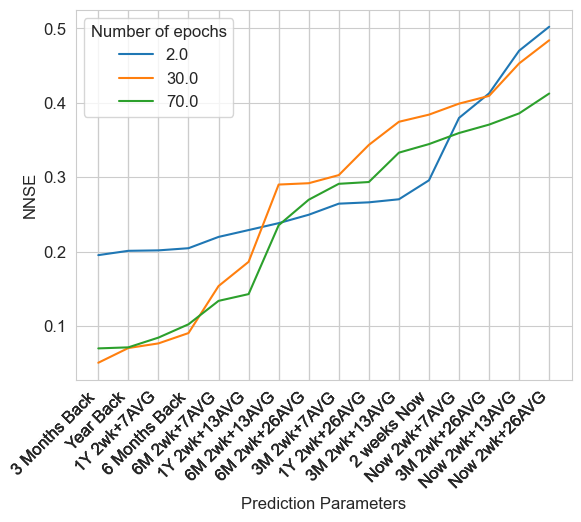

In [37]:
# df = mega_validation_dataframe.pivot(index='name', columns='epoch', values='NNSE')
# df.plot(figsize=(5,3))

fig, ax = plt.subplots()
for labels, dfi in mega_validation_dataframe.groupby('epoch'):
    dfi.plot(ax = ax, x = 'name', y = 'NNSE', label = labels)

ax.legend(title = 'Number of epochs')
plt.xticks(mega_validation_dataframe['index'], mega_validation_dataframe['name'])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right',
         weight='light')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Prediction Parameters")
ax.set_ylabel("NNSE")
image_file = Shell.map_filename(f'./images/NNSE-all-epochs-validation.pdf').path
plt.savefig(image_file, bbox_inches='tight')
fig.show()

In [38]:
for labels, dfi in mega_training_dataframe.groupby('epoch'):
    result_training = dfi[['name', 'NNSE']]
    result_training.sort_values('NNSE', inplace=True)
    result_training.rename(columns={'name': 'Name'},
                           inplace=True)
    display(result_training)
    content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
    content.insert(2, '\\hline')
    content.insert(-1, '\\hline')
    table_file = Shell.map_filename(f'./tables/{str(int(labels))}-training-NNSE.tex').path
    # content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
    # content = content.replace('\\\\', '\\\\\\hline', 1)
    writefile(table_file, '\n'.join(content))

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.1913
6,6M 2wk+7AVG,0.1927
10,6M 2wk+13AVG,0.1970
2,6 Months Back,0.2016
11,1Y 2wk+13AVG,0.2326
1,3 Months Back,0.2330
7,1Y 2wk+7AVG,0.2358
5,3M 2wk+7AVG,0.2430
15,1Y 2wk+26AVG,0.2516
14,6M 2wk+26AVG,0.2517


C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.0476
2,6 Months Back,0.0695
7,1Y 2wk+7AVG,0.0829
1,3 Months Back,0.0897
11,1Y 2wk+13AVG,0.1716
6,6M 2wk+7AVG,0.2081
15,1Y 2wk+26AVG,0.3196
5,3M 2wk+7AVG,0.3303
10,6M 2wk+13AVG,0.3418
9,3M 2wk+13AVG,0.3946


C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\2963654095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
1,3 Months Back,0.0674
3,Year Back,0.0735
7,1Y 2wk+7AVG,0.0831
2,6 Months Back,0.1053
6,6M 2wk+7AVG,0.1384
11,1Y 2wk+13AVG,0.1535
10,6M 2wk+13AVG,0.2521
14,6M 2wk+26AVG,0.2959
15,1Y 2wk+26AVG,0.3188
5,3M 2wk+7AVG,0.3354


In [39]:
for labels, dfi in mega_validation_dataframe.groupby('epoch'):
    result_training = dfi[['name', 'NNSE']]
    result_training.sort_values('NNSE', inplace=True)
    result_training.rename(columns={'name': 'Name'},
                           inplace=True)
    display(result_training)
    content = result_training[['NNSE', 'Name']].style.hide(axis="index").to_latex().splitlines()
    content.insert(2, '\\hline')
    content.insert(-1, '\\hline')
    table_file = Shell.map_filename(f'./tables/{str(int(labels))}-validation-NNSE.tex').path
    # content = content.replace("\\begin{tabular}{lrl}", "\\begin{tabular}{lrl}\n\hline")
    # content = content.replace('\\\\', '\\\\\\hline', 1)
    writefile(table_file, '\n'.join(content))

C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
6,6M 2wk+7AVG,0.1952
2,6 Months Back,0.2010
10,6M 2wk+13AVG,0.2016
3,Year Back,0.2045
1,3 Months Back,0.2197
5,3M 2wk+7AVG,0.2289
11,1Y 2wk+13AVG,0.2382
7,1Y 2wk+7AVG,0.2495
14,6M 2wk+26AVG,0.2644
9,3M 2wk+13AVG,0.2662


C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
3,Year Back,0.0505
2,6 Months Back,0.0703
7,1Y 2wk+7AVG,0.0765
1,3 Months Back,0.0904
11,1Y 2wk+13AVG,0.1536
6,6M 2wk+7AVG,0.1862
15,1Y 2wk+26AVG,0.2901
5,3M 2wk+7AVG,0.2919
10,6M 2wk+13AVG,0.3028
9,3M 2wk+13AVG,0.3434


C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.sort_values('NNSE', inplace=True)
C:\Users\stapm\AppData\Local\Temp\ipykernel_26496\1778794972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_training.rename(columns={'name': 'Name'},


,Name,NNSE
1,3 Months Back,0.0698
3,Year Back,0.0712
7,1Y 2wk+7AVG,0.0843
2,6 Months Back,0.1022
6,6M 2wk+7AVG,0.1337
11,1Y 2wk+13AVG,0.1428
10,6M 2wk+13AVG,0.2354
14,6M 2wk+26AVG,0.2697
5,3M 2wk+7AVG,0.2911
15,1Y 2wk+26AVG,0.2935


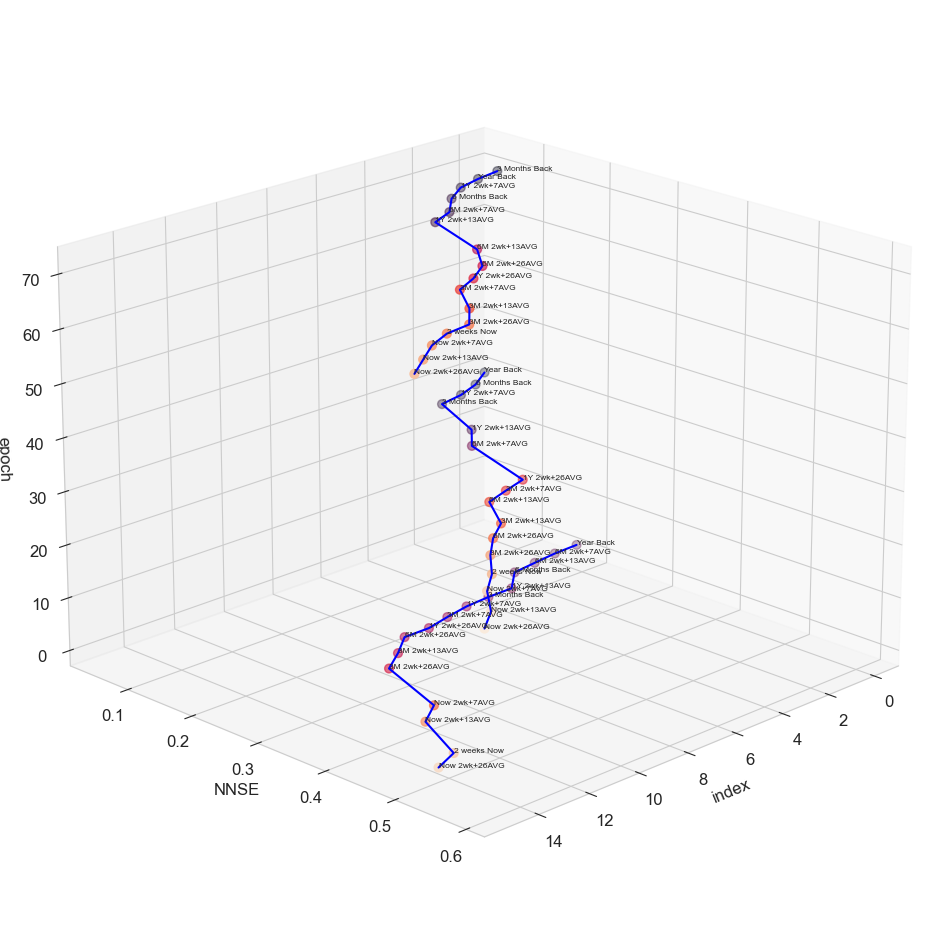

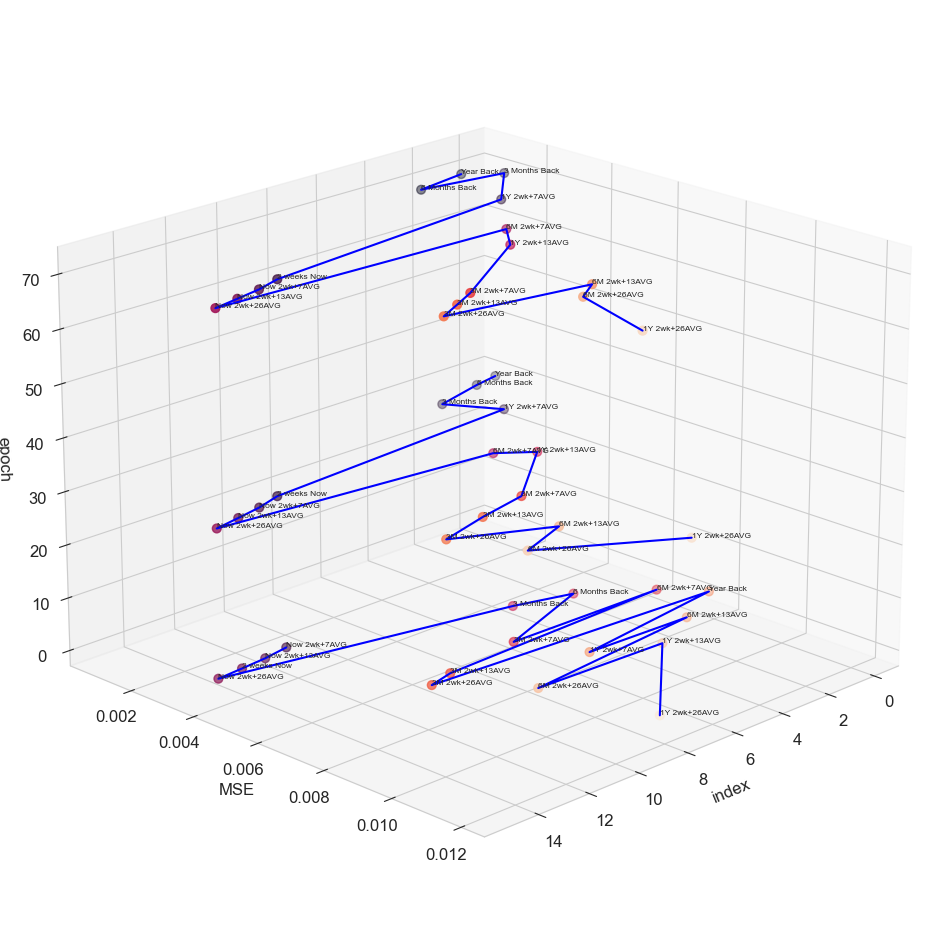

In [40]:
graphs = ['NNSE', 'MSE']
for graph_type in graphs:
    mega_training_dataframe.sort_values(graph_type, inplace=True)
    mega_validation_dataframe.sort_values(graph_type, inplace=True)

    cm = plt.get_cmap("RdYlGn")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('index')
    ax.set_ylabel(graph_type)
    ax.set_zlabel('epoch')
    ax.scatter(mega_training_dataframe['index'],
               mega_training_dataframe[graph_type],
               mega_training_dataframe['epoch'],
               # s=range(len(mega_training_dataframe['epoch'])),
               c=range(len(mega_training_dataframe['epoch'])),
               s=40,
               marker='o')
    for i in range(len(mega_training_dataframe)):
        x, y, z = mega_training_dataframe.iloc[i]['index'], mega_training_dataframe.iloc[i][graph_type], mega_training_dataframe.iloc[i]['epoch']
        ax.text(x, y, z, '{0}'.format(mega_training_dataframe.iloc[i]['name']), rotation=-45, rotation_mode='anchor', size=6)
    for epoch in epochs:
        temp_df = mega_training_dataframe.loc[mega_training_dataframe['epoch'] == float(epoch)]
        ax.plot(
               temp_df['index'], temp_df[graph_type], temp_df['epoch'],  # data
               #color='purple',                            # marker colour
               #marker='o',                                # marker shape
               color='blue'                                       # marker size
               )
    ax.view_init(20, 45)
    plt.show()
    # for idx, row in mega_training_dataframe.iterrows():
    #     ax.annotate(row['2weekIntervals'], (row['index'], row[graph_type], row['epoch']), rotation=0, fontsize=6)


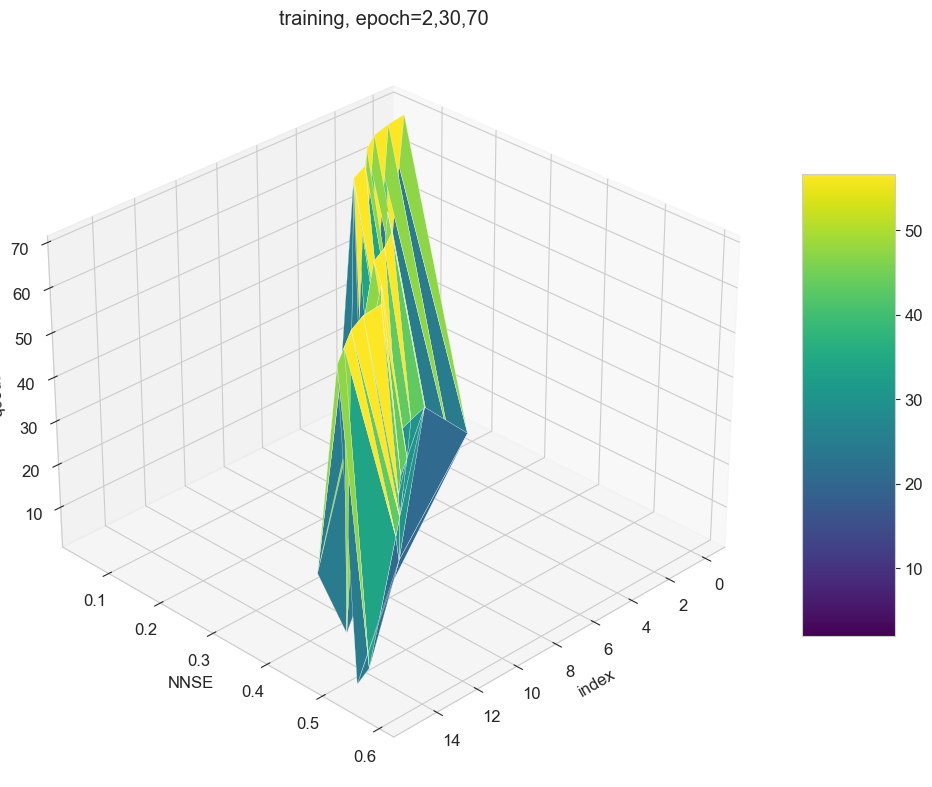

In [41]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
surf=ax.plot_trisurf(mega_training_dataframe['index'],
           mega_training_dataframe['NNSE'],
           mega_training_dataframe['epoch'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('index')
ax.set_ylabel('NNSE')
ax.set_zlabel('epoch')
ax.view_init(30, 45)
plt.title('training, epoch=2,30,70')
plt.show()